With help from https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

In [1]:
# Python setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image, ImageOps
from datetime import datetime


full_script_start = datetime.now()

In [2]:
# Code setup

current_dir = Path('.').absolute()
data_dir = current_dir /'data/motorcycles'


In [3]:
# Let's look at what data we have
# All images are stored in a directory with the name of the class
# We will build a data frame with the image name, file path and target


# Building a list of dicts makes it easy to convert to a data frame

targets = [target.name for target in data_dir.iterdir()]
image_metadata = []
for target in data_dir.iterdir():
    for image in target.iterdir():
        # Found a few directories that should not be there
        if not image.is_dir():
            image_metadata.append({
                'target': target.name,
                'path': image.as_posix(),
                'name': image.name
            })

image_data = pd.DataFrame(image_metadata)

print(image_data.shape)
print(targets)
print(len(targets))
    

(2890, 3)
['2010_indian_chiefbomberlimitededition', '2010_suzuki_boulevardc50t', '2011_benelli_centuryracer1130', '2011_triumph_america', '2013_indian_chiefvintagele', '2015_moto_guzzi_griso_8v_se', '2015_triumph_bonneville_newchurch_special', '2015_triumph_new_tiger_800_xcx', '2016_ducati_xdiavel', '2016_honda_cb300f', '2016_honda_crf250l', '2016_honda_nc750x_dct_abs', '2016_honda_xr650l', '2016_kawasaki_ninja_zx6r_abs_krt_edition', '2016_scrambler_sixty2', '2016_suzuki_boulevard_c50t', '2016_suzuki_boulevard_c90t', '2016_suzuki_boulevard_m90', '2016_suzuki_burgman_200abs', '2016_suzuki_burgman_650_executive_abs', '2016_triumph_bonneville_t120', '2016_triumph_rocket_iii_touring', '2016_triumph_street_twin', '2016_triumph_thruxton_1200', '2016_triumph_thunderbird_commander', '2016_triumph_thunderbird_storm', '2016_triumph_trophy_se', '2017_dr_z125l', '2017_ducati_1299_panigale_s', '2017_ducati_1299_panigale_s_anniversario', '2017_ducati_959_panigale', '2017_ducati_diavel', '2017_ducati

With so many classes, we cannot really plot them all. Let's get summary counts

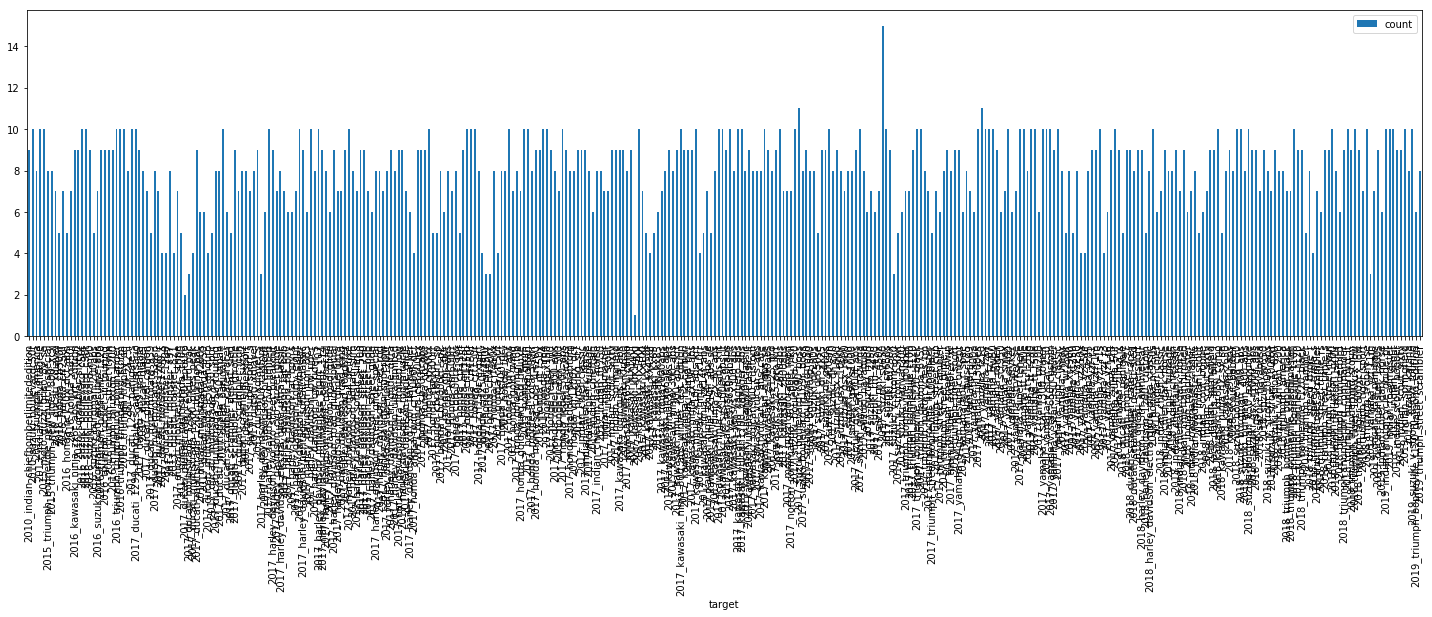

In [4]:
target_count = image_data.groupby('target')['name'].agg([('count', np.count_nonzero)])

target_count.plot.bar(figsize=[25, 6])

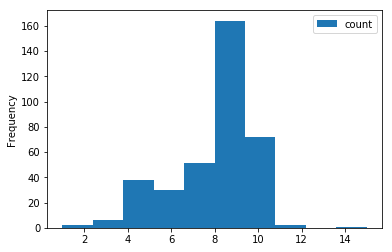

In [5]:
target_count.plot.hist()

Targets with the fewest items

In [6]:
target_count.sort_values('count')[0:10]

count
target                                        
2017_kawasaki_klx140g                        1
2017_ducati_multistrada_1200_enduro          2
2018_yamaha_yzf_r1m                          3
2017_honda_crf450rx                          3
2017_ducati_multistrada_1200_enduro_pac      3
2017_honda_crf450r                           3
2017_harley_davidson_1200_custom             3
2017_suzuki_v_strom_650                      3
2017_honda_crf250l_rally                     4
2017_ducati_multistrada_1200_pikes_peak      4

Targets with the most values

In [7]:
target_count.sort_values('count', ascending=False)[0:10]

count
target                                         
2017_suzuki_sv650                            15
2017_suzuki_boulevard_c90_boss               11
2017_yamaha_fz10                             11
2017_yamaha_pw50                             10
2017_triumph_bonneville_t120_black           10
2017_triumph_daytona_675r                    10
2017_harley_davidson_milwaukee_eight_107     10
2017_yamaha_fjr1300es                        10
2017_harley_davidson_low_rider               10
2017_yamaha_fz6r                             10

Now let's look at image sizes. I've never worked with PIL, so let's test a single image

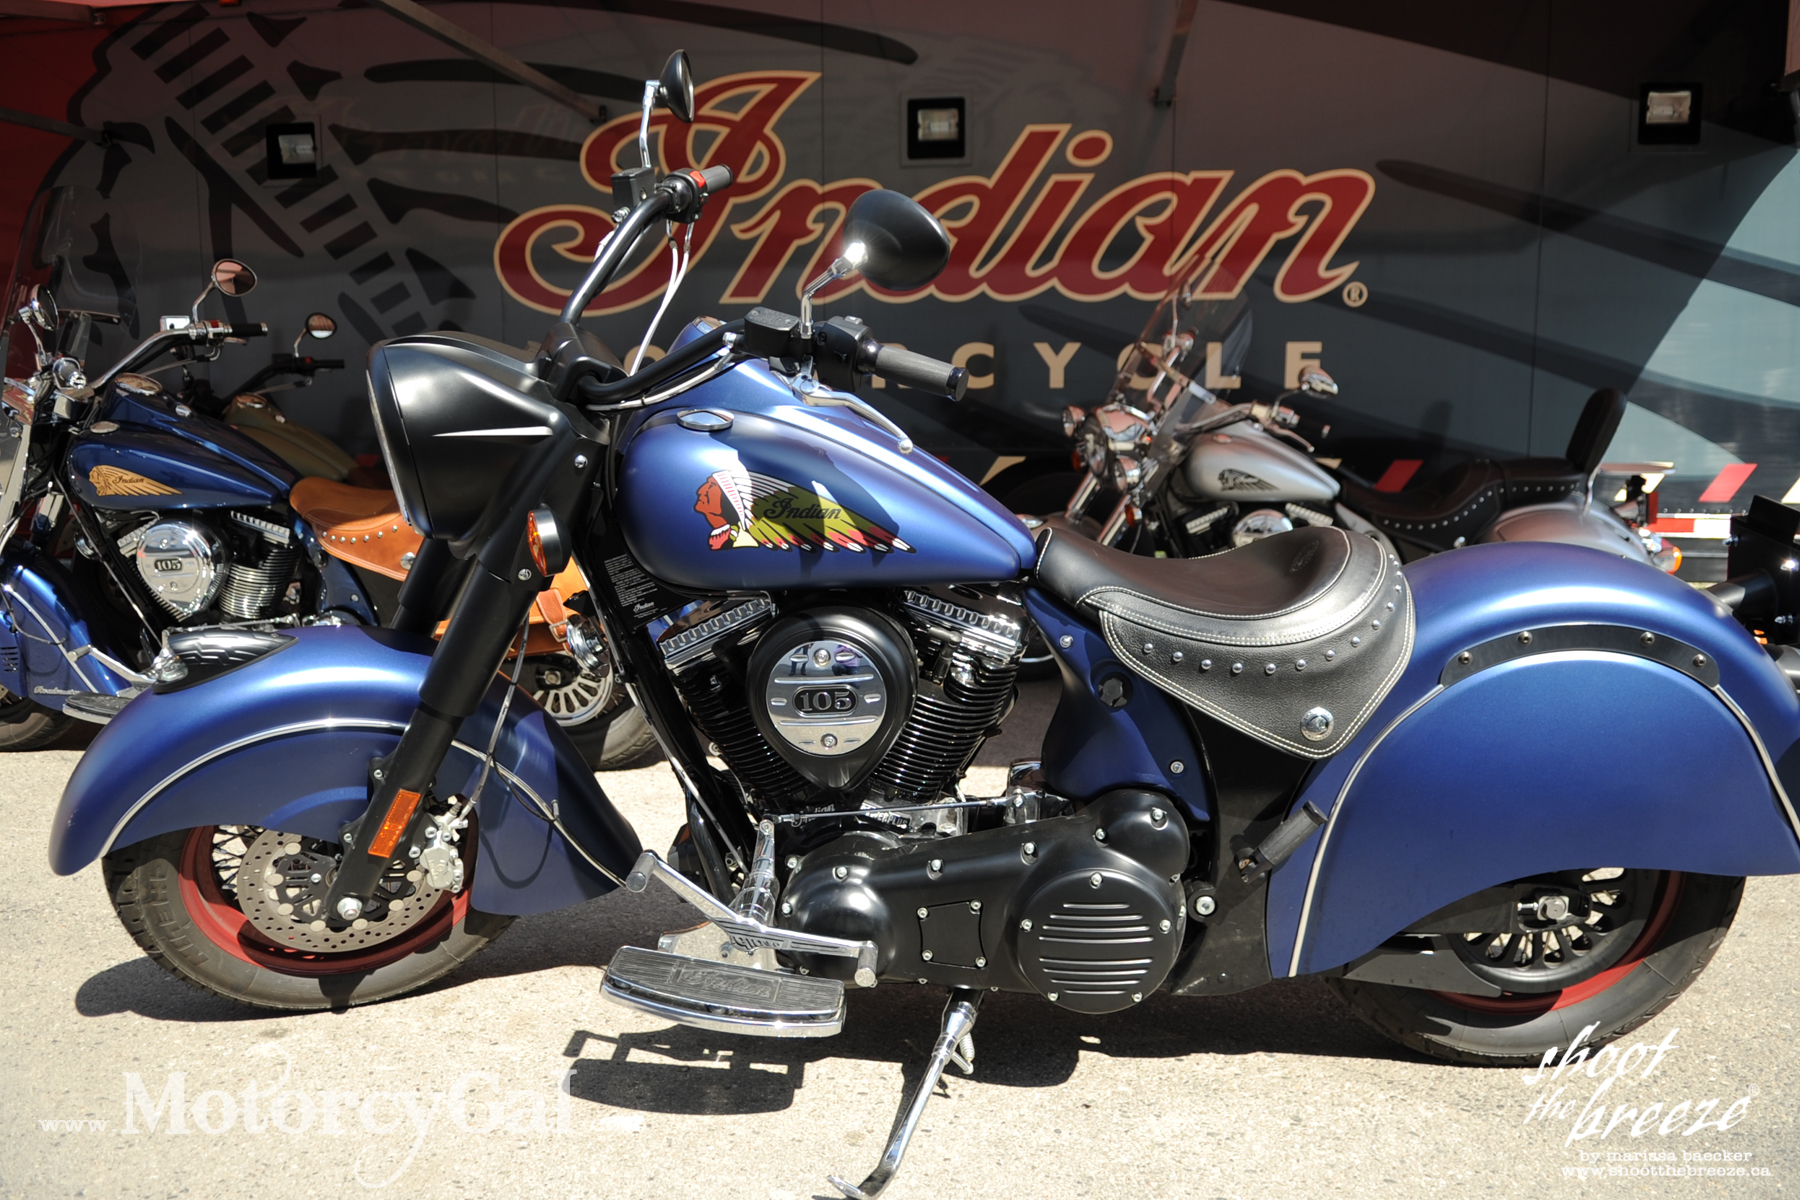

In [8]:
image_path = image_data.iloc[0]['path']
first_image = Image.open(image_path)
first_image

    Well, that's cool. Very easy. What can we do with images?

In [ ]:
dir(first_image)

['_Image__transformer',
 '__array_interface__',
 '__class__',
 '__copy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_close_exclusive_fp_after_loading',
 '_copy',
 '_crop',
 '_dump',
 '_ensure_mutable',
 '_exclusive_fp',
 '_expand',
 '_getexif',
 '_getmp',
 '_min_frame',
 '_new',
 '_open',
 '_repr_png_',
 '_seek_check',
 '_size',
 'alpha_composite',
 'app',
 'applist',
 'bits',
 'category',
 'close',
 'convert',
 'copy',
 'crop',
 'custom_mimetype',
 'decoderconfig',
 'decodermaxblock',
 'draft',
 'effect_spread',
 'encoderconfig',
 'encoderinfo',
 'filename',
 'filter',
 'format',
 'format_description',

Size: 1800x1200


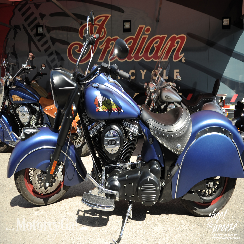

In [ ]:
print(f'Size: {first_image.width}x{first_image.height}')

smaller = first_image.resize((244, 244))
smaller

Since most of my images are wider than they are tall, I wonder if resizing to a square will cause problems. For now, let's collect width and height data. Took a lot

In [ ]:
begin = datetime.now()
images = image_data['path'].apply(lambda path: Image.open(path))
end = datetime.now()
print(f'Opened images in: {end - begin}')

Opened images in: 0:00:12.277315


In [ ]:
image_data['width'] = [image.width for image in images]
image_data['height'] = [image.height for image in images]
image_data['ratio'] = [image.width / image.height for image in images]

I'm not sure if resizing images which will distort them will cause a problem. Center cropping will definitely cut some of the features, but random cropping may work well. I will have to test this. Here is an example where someone did the same. 

I believe since most of these images are professional, they are already cropped well. therefor, random cropping should yeild good results. I like the black boder approach. It would allow resizing of the test images without distorting them. I found a post on this: https://stackoverflow.com/questions/11142851/adding-borders-to-an-image-using-python



https://forums.fast.ai/t/impact-of-image-resizing-on-model-training-time-and-performance/1980

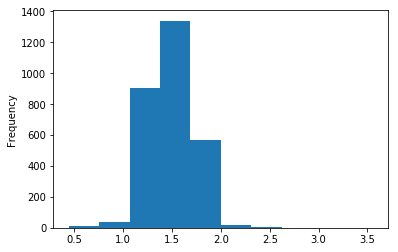

In [ ]:
image_data.ratio.plot.hist()

In [ ]:
print(f'First image size: {first_image.width}x{first_image.height}')

First image size: 1800x1200


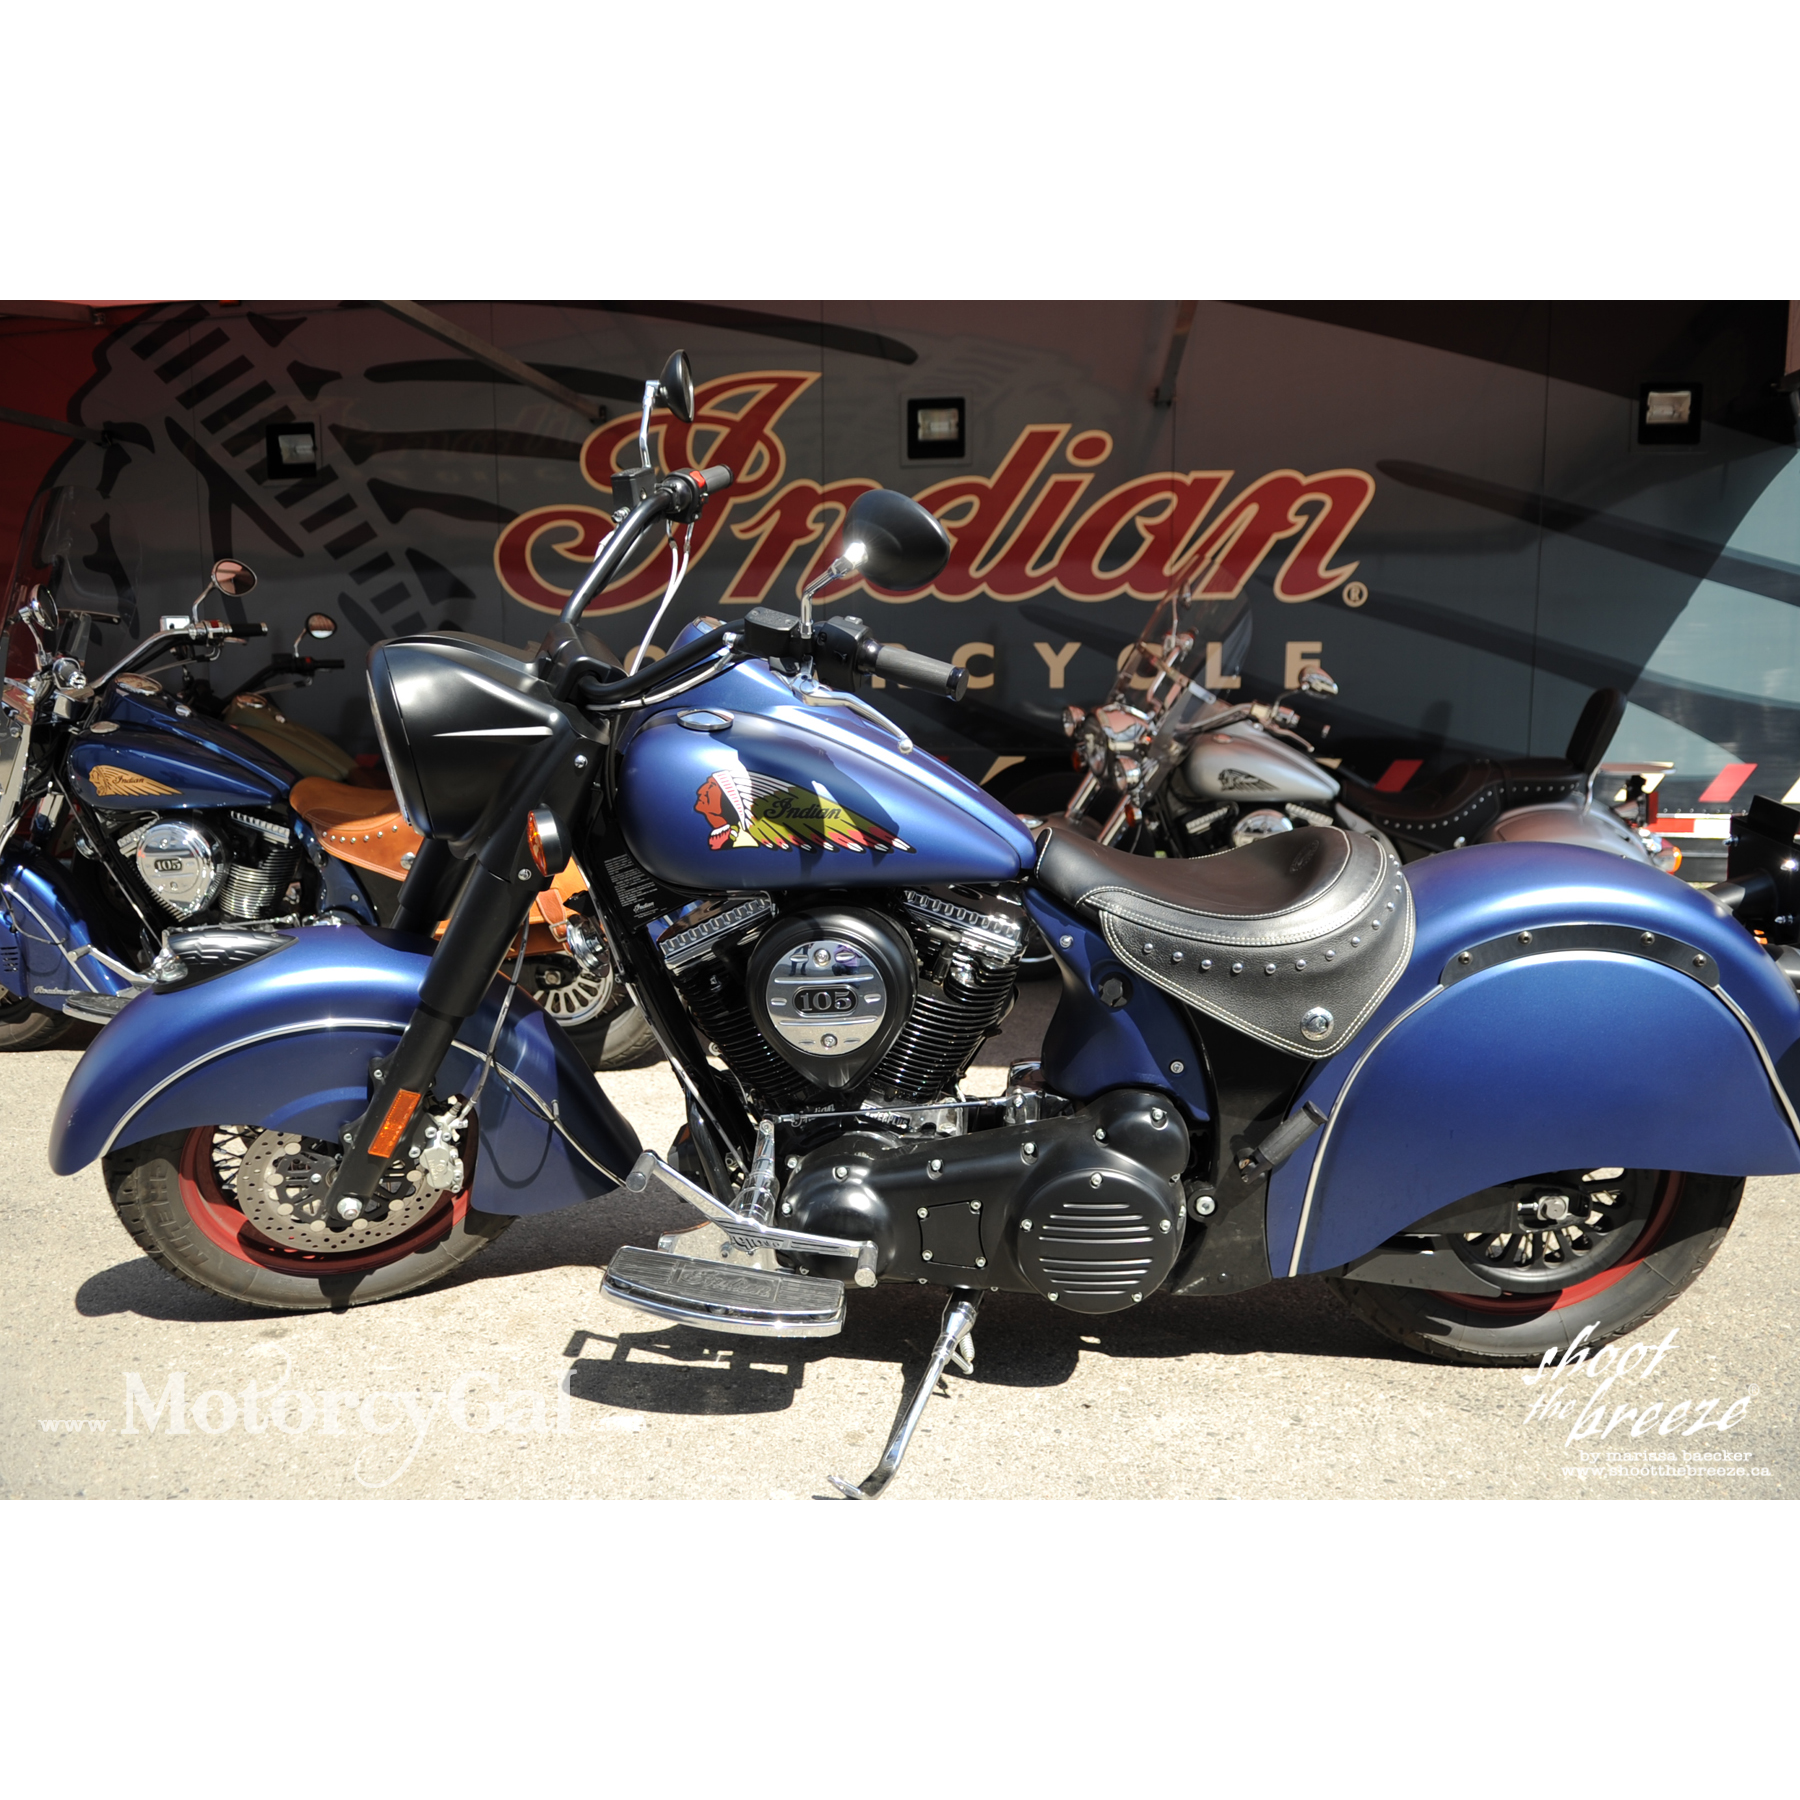

In [ ]:
square_image = ImageOps.expand(first_image, border=(0, 300), fill="#ffffff")
square_image

Let's add white borders to the images to make them square. Then we can resize them as needed and test resizing vs random cropping (random cropping probably will not work well

In [ ]:
square_dir = Path('.').absolute() /'data/square_motorcycles'
square_paths = []
square_success = []

begin = datetime.now()
for index, row in image_data.iterrows():
    print(row['path'])
    target_path = square_dir /row['target']
    target_path.mkdir(parents=True, exist_ok=True)
    square_path = target_path / row['name']
    square_paths.append(square_path)
    # Some images fail due to a bug in PIL. Since it is only a few, I will simply skip them.
    try:
        image = Image.open(row['path'])
        if image.width > image.height:
            border_add = int((image.width - image.height) / 2)
            square_image = ImageOps.expand(image, (0, border_add), '#ffffff')
        else:
            border_add = int((image.height - image.width) / 2)
            square_image = ImageOps.expand(image, (border_add, 0), '#ffffff')
        square_image.save(square_path)
        square_success.append(1)
    except:
        print('Adding border failed')
        square_success.append(0)
end = datetime.now()
print(f'Added borders in {end - begin}')
image_data['square_path'] = square_paths
image_data['square_success'] = square_success

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2010_indian_chiefbomberlimitededition/1cbac4ca-25bd-4843-9d3e-2cedaf3195d0-indian-chief-bomber-limited-edition-2010-moto.jpeg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2010_indian_chiefbomberlimitededition/3e664308-bb7e-43d6-b335-846d85a03cb3-2010-Indian-ChiefBomberLimitedEditiona.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2010_indian_chiefbomberlimitededition/4a90efee-c063-455c-826b-6e1c40953bb1-indian-chief-bomber-limited-edition-2010-moto.jpeg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2010_indian_chiefbomberlimitededition/877f1113-674f-4a69-8ffe-52f26a3ac1a2-2010-Indian-ChiefBomberLimitedEditione.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2010_indian_chiefbomberlimitededition/a4b222ed-ccf0-4458-a954-7440dab4ffb2-2010-Indian-ChiefBomberLimitedEditionb.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2010_india

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2015_triumph_bonneville_newchurch_special/bef89b47-452e-4e66-9266-880a956623a7-2015-Triumph-Bonneville-Newchurch-Special1.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2015_triumph_bonneville_newchurch_special/c00d4632-bd52-40df-8487-6f8ca17394ef-DSC05595_1485881884.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2015_triumph_bonneville_newchurch_special/fa422a48-0f72-4a89-913d-7cc9371d026f-2015-triumph-bonneville-newchurch-special-edition-americanlisted_42453897.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2015_triumph_new_tiger_800_xcx/0058abab-929c-41cb-8463-248079b18bd6-Triumph_tiger_800_xcx_2015_4.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2015_triumph_new_tiger_800_xcx/3471e10f-79a7-4a86-9727-f95b6081b5e2-2015-Triumph-TIGER-800-XCx-Motorcycles-For-Sale-41252.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/201

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2016_triumph_bonneville_t120/829951c9-3702-49a7-b32e-0da8d675c333-102715-2016-triumph-Bonneville-T120-Cinder-Red-Left.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2016_triumph_bonneville_t120/9815cb13-20b9-4c85-8188-fb2a6fd9f820-large_triumph_bonneville_t120_2016_3d_model_3ds_fbx_c4d_dxf_obj_max_ddf902fb-4653-4d64-af77-3490d1ce005d.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2016_triumph_bonneville_t120/ab40f410-87ed-4413-8034-ffdc1b133b37-triumph_T120_bonneville-631x389.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2016_triumph_bonneville_t120/cff4a2a2-55aa-4b84-ba9f-61e0a1e963c3-bonnevillet120_4.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2016_triumph_bonneville_t120/d6138a23-b0bb-40c9-a16a-18abfc132db7-bonneville05.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2016_triumph_bonneville_t120/ec57c2be-8ba8-468b

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2016_triumph_thunderbird_storm/f5347a1d-ccff-4c8e-8ee5-e62714b95871-2016-Triumph-Thunderbird-Nightstorm3.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2016_triumph_trophy_se/0167014b-db0b-4eff-89da-c3e25f98c72c-2016-triumph-trophy-se-motorcycles-in-scottsdale-az.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2016_triumph_trophy_se/17ffaf6f-5628-4995-9145-c473dfdd6bd8-35357862566_d832d5cc74_o.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2016_triumph_trophy_se/28eaac92-1223-4e0d-b31a-32fe40cff14f-6000000008.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2016_triumph_trophy_se/39703cf8-65b9-4dd0-af85-aa1c332d6ea1-triumph-1200-trophy-SE-2016-700px.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2016_triumph_trophy_se/5ce0a5a0-a856-41f0-8776-9bf910a80137-2016-Triumph-Trophy-SE3.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practi

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_diavel/3be5f562-40ca-4895-b4a6-c20ab88d952a-ducati-diavel-2017-17.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_diavel/47a09179-d0bb-40ff-b579-782839987aad-2017-Ducati-Diavel-Diesel-Launched-In-India-Price-Engine-Specs-Features-2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_diavel/4aa34ee8-f99e-4863-b357-052ebc93e32f-2017-ducati-diavel-diesel-motorcycles-in-greenville-sc.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_diavel/b1eb562a-2e5f-4fb2-9b65-a92b55d1e871-2017-ducati-x-diavel-s-for-sale-in-fort-myers-fl-motorcycles-in-fort-myers-fl.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_diavel/b9812d08-4170-459b-ab6f-a930c15e49b5-ducati-diavel-2017-3.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_diavel/c8b8fd8a-929b-4b30-93b5-9998e71c86d0-ducati-dia

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_monster_821/e81f863b-7daf-4a29-9547-19e9de2f33c6-2017-Ducati-Monster-821b.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_monster_821_stripe/129bd5a6-7018-4e39-bdbd-aefed0ef2b6f-2017-Ducati-Monster-821-STRIPE1.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_monster_821_stripe/34d6965d-98f3-4515-93b5-584140c2f7a1-hqdefault.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_monster_821_stripe/4c60ae01-efe9-4101-8978-6c8681659165-34317661214_9f3802dd84_b.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_monster_821_stripe/585bec8d-ca9d-4d2d-897a-a6c75d25016c-2017-Ducati-Monster-821-STRIPE2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_monster_821_stripe/91eb8741-f806-46ec-b789-869a14b8f1f0-2000000007.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/moto

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_multistrada_950_spor/c2168012-3de3-4687-9c95-d68a0085a14d-110716-2017-ducati-multistrada-950-26.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_multistrada_950_touring/1bb9dfe5-5a84-48d8-b6b4-5936f3aa17fb-ducati_multistrada_950_touring_pack_17.jpeg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_multistrada_950_touring/5f248f1d-60f4-4e54-8059-5d6b754f2860-ducati_multistrada_950_touring_pack_7.jpeg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_multistrada_950_touring/6e25cdbc-c8f9-41bf-a65f-4e39290ff930-multistrada_950_red_tp_01-1600x1200.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_multistrada_950_touring/76035554-b681-4ca8-963e-924f73a9ef9d-2017-Ducati-Multistrada-950-22.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_multistrada_950_touring/9aaa0160-7df5-

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_scrambler_icon/0c435ad7-356a-4a06-ac32-62dbe10af9ce-12244811_10153213766346074_8204132114851235537_o.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_scrambler_icon/2a6d5ec1-65c8-4eb9-b080-e8595257d8cc-ICON%20NEW%20YELLOW%201_0.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_scrambler_icon/68d4d118-fdcc-4f08-bb6a-d8b1c1b1102c-scrambler-icon-red%20angle_0.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_scrambler_icon/84d5c1db-3c4d-4e8f-9f4a-2b570fe7a6d2-2000000003.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_scrambler_icon/b9b2ee07-a677-4846-b12e-b84860ae390d-6000000008.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_ducati_scrambler_icon/d0557d0c-b8f6-4c45-88ac-8735cd567a96-2017-Ducati-Scrambler-Icon4-small.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/d

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_breakout/6cc43c8a-9c83-496f-adaf-4884cdc8c937-Harley-Davidson-Softail-Breakout-2017.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_breakout/d85b2745-d9c8-4330-8640-1124d09c63e5-1499315aa77342_low_res_2017-harley-davidson-softail-breakout-fxsb.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_cvo_limited/008303b2-6551-405a-bf42-bf10fd3d8f3c-8ce0daf0979cefbfae78310c80b8ca4ex.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_cvo_limited/1af70d2e-5804-43f5-ae8f-8234b7f18163-2017-Harley-CVO-Ultra-Limited-action-R.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_cvo_limited/63c8020a-e5c5-4629-a0a3-621b34670d87-harley-CVO-1870-electra-glide-ultra-limited-2017-700px.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_fat_boy/f78b6e05-ab5f-4993-b4f8-7e951757ec1d-Harley-1690_SOFTAIL_FAT_BOY_SPECIAL_FLSTFB_2017_700px.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_fat_boy_s/060faab9-e58b-4f76-8cee-aa7ec2bdacd5-DSC04225.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_fat_boy_s/2960073c-c7d7-4c4b-b9fe-3f088d5c060e-Harley-Davidson-1800-Fat-Boy-S-2017-700px.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_fat_boy_s/3a652f97-88bd-4dd4-9278-788483dfc14d-2017-harley-davidson-fat-boy-s-motorcycles-in-cloquet-mn.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_fat_boy_s/8b20db54-c72d-47e2-825e-c33752dd524b-Harley-Davidson-2017-Fat-Boy-S-side-look.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_fat_boy_s/c231ef39-d755-44b2-8251-

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_low_rider/f0084907-b965-4753-a639-6b5204709337-Harley-Davidson-2017-Dyna-Low-Rider-action.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_low_rider_s/3edfcf3b-1618-4e74-a30f-5fdc933d1ed0-Harley-Davidson-Dyna-Low-Rider-S-2017-3840x2160-001.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_low_rider_s/443219cd-efdb-462f-93a6-abc4b0d974af-Harley-Davidson-2017-Low-Rider-S-view.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_low_rider_s/4ac90214-6e61-4bbb-bbef-6ca8bf13dc53-Harley-Davidson-2017-Low-Rider-S-front.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_low_rider_s/68f3475b-73a5-4843-a0a0-cbfff4488278-2017-harley-davidson-dyna-low-rider-buyers-guide-1-1024x683.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davi

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_road_glide/89974c34-624b-4fd8-81cf-7e85f331b148-2017-Harley-Davidson-Road-Glide-design.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_road_glide/b321f9ec-34a9-4626-b43d-39d33407a3e0-2017-Harley-Davidson-Road-Glide-Ultra2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_road_glide/f0f86057-5a67-4f42-818a-41883bc787c3-2017-Harley-Davidson-Road-Glide-front-view.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_road_glide_special/1d4af7a1-3ba7-4fbd-83cb-faac59c188a3-2017-harley-davidson-road-glide-special-buyers-guide-1.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_road_glide_special/487b602c-d36c-4245-85d6-b421cd1e41dc-2017-harley-davidson-road-glide-special_827x510_71479894448.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_softail_slim_s/4830b569-8cb6-40d1-83cb-cf7b13e86132-E0D017BC-D2EF-4287-8651-349A285B2560.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_softail_slim_s/754afa05-318e-4437-8afc-2206c21e51c0-2016-h-d-softail-slim-s-2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_softail_slim_s/80d7d56c-4fd3-4287-b198-692185a0cf89-2017-Softail-Slim-S-Harley-Davidson-side-view.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_softail_slim_s/8ee5c02f-b9c6-4181-9199-c40239e2020f-Harley-1800-Softail-Slim-S-2017-700px.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_softail_slim_s/fc2d630e-66e6-4fd2-a0d8-f44fc11d4658-6000000001.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_street_500/28f30541-6939-4851-991e-ab0f175dbbcd-6000

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_street_rod/a1fa770a-b6f8-47ad-ae53-ba8b3c4fffbb-Harley-Davidson-Street-Rod-3-of-17.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_street_rod/a39ab0d9-3469-4a01-a143-240fa895bd76-Harley-Davidson-Street-Rod-3qtrR.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_street_rod/a562877f-ad4a-4c5c-8e0d-92537d7224ae-2017-harley-davidson-street-rod-19-625x417.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_street_rod/e2474523-170d-4db3-a6fc-95dc38cac727-harley-street-rod-2017-1.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_superlow/3fe7a981-a5a2-4dee-b73f-279f9eaffa05-2017-hd-superlow-120-7.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_superlow/5d7d9f6c-020a-4610-ade7-967d2542cd45-2017-Sporster-SuperLow-1200

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_v_rod_muscle/431a20df-7633-4ac0-b372-a171b73650ba-131459d7adb398_hd_2017-harley-davidson-v-rod-muscle-vrscf.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_v_rod_muscle/6f49c455-1488-4b2a-bf55-1d5e726c8a73-2016_h-d-v-rod_muscl-14.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_v_rod_muscle/7491af5e-583e-4861-8190-790a66046968-2000000002.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_v_rod_muscle/9ce18ed0-7da6-4516-ac9f-158e8a870ca1-Harley-Davidson-2017-V-Rod-Muscle-rear-style.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_v_rod_muscle/cc4459db-546e-4c09-a265-b4934c78f9e1-867250971b.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_harley_davidson_wide_glide/03288b6b-e92a-4901-a907-51e6c37d18c5-2000000003.jpg
c:/Users

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_cb500x/2689c436-22bc-490a-a75a-97b233716e83-2017-honda-cb500x-review-specs-adventure-motorcycle-bike-cb500-x-3.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_cb500x/2eeb24a0-e9fa-4b9a-bc3c-2c85570c1298-2017-honda-cb500x-rear-view.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_cb500x/3f2dfe2b-64fa-43bc-8d0c-c0df1df78b10-2017-honda-cb500x-front-view.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_cb500x/57863095-333a-44d9-a884-58b64c91eee9-maxresdefault.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_cb500x/8d09ec8c-1e13-4571-b99a-f5f256662a7d-2017-Honda-CB500X-10.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_cb500x/8f33389d-8242-49cc-8531-48b980c689bf-2017-Honda-CB500X-review-40-630x420.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/201

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_cbr600rr_abs/883f7881-8847-40cb-8351-f60b7f8453a0-HONDA-CBR600RR-ABS-14028_12.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_cbr600rr_abs/d84a4615-ac83-4abe-b1c5-d23ff6f3e2f1-hqdefault.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_cbr600rr_abs/dde52ce0-5a6d-4f80-ac62-c07f5f90de21-2017-honda-cbr300r-abs-motorcycles-in-tarentum-pa.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_cbr600rr_abs/e43a8a0f-45f3-423f-944c-7196d802a401-2017_honda_cbr600rr_sport_002.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_cbr600rr_abs/f510dd80-c81d-47fd-8545-ab382e3f13b8-2017-honda-cbr600rr-abs-motorcycles-in-lake-geneva-wi.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_crf110f/05c31171-1c16-4c82-9306-8a3c778c0ff6-2017-Honda-CRF110F3.jpg
c:/Users/leogo/OneDrive/regis/MSDS/prac

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_crf250l_rally/4ffd49b1-6156-4574-becf-96cdefdb48a2-050317-2017-honda-crf250l-rally-Rousseau-2017_HondaCRF250L-B.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_crf250l_rally/cc0a955f-687d-4638-a1e9-49ad0677f7cf-110716-2017-honda-crf250l-04.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_crf250l_rally/f8d4b707-e0da-4480-98a4-5ea6e0e66db3-2017-Honda-CRF250L-Rally-24.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_crf450r/033b909b-1f56-4006-9e54-3b75dd9e1fcc-s1200_13582324_1819874468242387_1453600914_o.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_crf450r/0841885e-242d-47a3-af8f-4f348c1d48a5-110116-2017-honda-CRF450R-MO-B-Rousseau.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_crf450r/c799cc72-d179-47a0-b4c3-1bf2fd7df948-2017-Honda-CRF450r-Honda-Suspension_Ohl

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_gold_wing_f6b/2a1dd9c0-beb6-49cd-a6e1-68bfc7dae9a5-honda-goldwing-goldw-5.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_gold_wing_f6b/2d45afab-161d-4346-9d94-dd7ad25de704-2017_honda_gold-wing-f6b_tourisme_004.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_gold_wing_f6b/590a7994-8b34-4a9e-9479-8b85a1260991-2017_honda_gold-wing-f6b_tourisme_006.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_gold_wing_f6b/6688d995-93a7-4838-b00b-9cf09593b1b9-2017-Honda-Gold-Wing-F6B-Deluxe1.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_gold_wing_f6b/854766b7-091d-469b-b343-087cc0bc060d-2017-2016-honda-gold-wing-f6b-new-touring-ride-specs-prices-regarding-2017-honda-f6b.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_gold_wing_f6b/87cab0bb-1976-4993-b57a-48023b72d381-2017_ho

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_montesa_cota_4rt260/bd6678cf-6d85-4947-8c38-6b33516876c4-2017-honda-montes-cota-4rt260-special_edition-002.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_nc750x/22d9585d-0644-435c-bc4e-a0ac6e6eed28-2016-Honda-NC750X-DCT-ABS2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_nc750x/2630983b-2945-4831-acc0-4fca44cb756a-2017-Honda-NC750X5.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_nc750x/41695dbd-3a5f-44ef-8916-b6f0c529d5cc-12.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_nc750x/4a3c153d-0ee3-4d01-bcb7-96bf7bbf9782-maxresdefault.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_nc750x/9c672b5e-c5b9-4ad3-946a-e863c54df428-big-honda-nc750x-motorcycle-rental-in-barcelona-spain.jpeg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_honda_nc750x

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_indian_chieftain_dark_horse/ba5c86e3-e91c-4a41-9643-b392bc8c93c6-2017-Indian-Chief-Dark-Horse3.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_indian_chieftain_dark_horse/d4197946-93f8-46db-b889-e35272b5a7c2-2017-Indian-Chieftain-Dark-Horse.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_indian_chieftain_dark_horse/d57d0089-de91-4f74-a373-5d2ccd55ae9c-2017-Indian-Chieftain-Dark-Horse2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_indian_chieftain_dark_horse/e59c5eb7-8979-42d7-b7e0-c6b96d329238-2017-Indian-Chieftain-Dark-Horse-08.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_indian_chief_classic/014e7c9d-0bc2-42b7-bd1b-676c8453309b-2017-Indian-Chief-Vintage.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_indian_chief_classic/0abab611-a7bd-4490-8fda-80c2fa9edab3-Indian_Chief_Classic-38.jpg
c:/

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_indian_scout_sixty/06fa21cf-44e6-41fa-a4a7-70fa430692ec-2017-imc-scout-sixty-7_800x0w.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_indian_scout_sixty/6ce5e112-282e-4f2f-94e8-3bd716e36133-6000000020.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_indian_scout_sixty/6e87ce42-8b67-45d5-8edc-a7b0ed2d156a-2017-Indian-Scout-Sixty1.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_indian_scout_sixty/96360fbc-3c64-4168-b9a0-50eff761b246-2017-Indian-Scout-Sixty.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_indian_scout_sixty/98cabe58-bba3-4388-a81d-2428a745c5db-137414de715def_hd_2017-indian-scout-sixty-abs-.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_indian_scout_sixty/b61b188f-3834-487c-ae2c-e3251e558666-Indian-Scout-Sixty.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_i

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_klx140g/287aa06c-b945-44ab-8619-d8b16f7df7e2-6000000002.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_klx140l/0afeceaa-c729-4d2b-88c1-e724dd1a95c6-maxresdefault.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_klx140l/7c39fa5d-fa5d-40aa-8afe-5f4dd276b55c-6000000003.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_klx140l/87615489-08a3-4dbf-82e4-c399a7bc2b12-2000000019.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_klx140l/95bb3c96-7326-4ffb-b70b-751820c7507e-qf0vzwng.ihn.png
Adding border failed
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_klx140l/a082992f-61df-43c0-ae9a-81a248842bf8-6000000001.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_klx140l/a25fb71e-7b6f-4ee1-bb74-8f1fbbc5634d-6000000002.jpg
c:/Users

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja650_abs_krt/614816fb-b715-4e6d-afd2-dda3e7679071-2000000004.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja650_abs_krt/6985e7e5-6b18-4cd6-a011-e0b9bd811d7b-2017-Kawasaki-Ninja-650-ABS-KRT-Edition-Speed.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja650_abs_krt/6f18a1be-aa4e-496f-a1c4-8e6e48bdaad0-2000000006.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja650_abs_krt/943ee9c1-e91a-4321-85b0-5a2e3a2db52f-6000000001.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja650_abs_krt/ad87dc7b-c63b-4167-8ce3-4585f5e97872-15063.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja650_abs_krt/d28a0101-e859-430e-bb7f-5f9353b4b23f-2017-Kawasaki-Ninja-650-ABS-KRT-Edition-Specs-2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja_zx10rr/324ede40-d793-4018-9181-3bf27b93fa5c-2017-Kawasaki-Ninja-ZX-10RR-front-right-quarter.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja_zx10rr/d2036200-a20d-4aaf-82f4-550dcc1a7b3b-fnusx41o.fck.png
Adding border failed
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja_zx10r_abs/12579e04-4614-4244-8d53-59a54082e622-kawasaki-2017-ninja-zx-10r-abs.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja_zx10r_abs/19623e86-723f-4e01-bcb3-94324638d5c3-maxresdefault.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja_zx10r_abs/432d1060-19bd-44e8-ac20-6271a4e4d7cd-2017-Kawasaki-Ninja-ZX-10R-ABS-SuperSport-Bike.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja_zx10r_abs/470de4f2-d9ca-4fe5-85c9-3a4686e5b473-2017-Kawasaki-Ninja-ZX10R-

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja_zx_6r_abs_krt/843a065f-b1d4-47e6-93e5-5a12299b4de1-9C2841D3-32D2-4481-A588-361E3975CA09.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja_zx_6r_abs_krt/8f73a6ac-f0e2-4d55-97c2-fdb247a645dc-Kawasaki-2017-Ninja-ZX-6R-ABS-KRT-Edition-Sports-Speed.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja_zx_6r_abs_krt/9a218706-a3b9-4252-9e06-446c880d2df5-2018-Kawasaki-Ninja-ZX-6R-ABS-KRT2-1024x767.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja_zx_6r_abs_krt/d3d80b96-992a-426b-9ab1-d0328f299ca4-wwbkgqui.13d.png
Adding border failed
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_ninja_zx_6r_abs_krt/fa60c260-f825-49a5-8622-44739f3a935b-kawasaki-zx-2017-kawasaki-zx636fhfal-ninja-zx-6r-abs-krt-edition-jaune_66210802.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/mot

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_vulcan1700_vaquero_abs/d865f82a-f44a-4515-9416-292c41466a80-Kawasaki-2017-Vulcan-1700-Vaquero-ABS-Ride.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_vulcan1700_vaquero_abs/fe9be747-946b-4953-8f8d-d2f51468878e-2000000009.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_vulcan1700_voyager_abs/0536c538-1972-4bfb-896d-de1e1a87f3c6-6000000004.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_vulcan1700_voyager_abs/0e227930-8c54-41fa-be84-73ad3478a081-D70170C5-B8DD-4BB3-96A3-F9200D083A4F.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_vulcan1700_voyager_abs/13d6705a-9604-4038-a3e2-1f2cbb117abb-2017-Vulcan-1700-Voyager-ABS-Kawasaki-Specs-2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_vulcan1700_voyager_abs/1eb887fd-5004-4d17-94f1-2f022246615e-2000

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_vulcan_s_abs_cafe/f4575e6a-d2db-49c6-b4ff-f24582fd69a6-kawasaki-vulcan-s-abs-cafe-2017-18.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_vulcan_s_abs_cafe/f505365b-1d5f-4b9a-b985-422d387d97ad-2017-Kawasaki-Vulcan-S-ABS-Cafe-Cruisers-Side.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_vulcan_s_abs_se/03b4a96a-0c26-48c6-8b4b-146a4e9b3fc6-5942-KAWASAKI-VULCAN-S-SE-ABS-2017.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_vulcan_s_abs_se/068764a1-baa8-4ea9-9927-7b396244bde2-6000000006.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_vulcan_s_abs_se/1f82a04c-f6a4-4393-8d87-dbe7a9651bb6-maxresdefault.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_vulcan_s_abs_se/2555f082-2125-445f-9cc8-c55ee04ce88f-kawasaki_vulcan_650_se_abs_2017_1.JPG
c:/Users/le

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_z900abs/ca8a9985-b0ad-46bd-8401-fb01222e43d5-17ZR900B_540BU1DORF2CG_C.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_kawasaki_z900abs/ee0b07b2-39a7-40b0-9376-578f812e4f48-DSC04173.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_moto_guzzi_eldorado_men/2c3aff10-d269-4c09-9ab9-6edffa27fa68-2017-Moto-Guzzi-Eldorado3.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_moto_guzzi_eldorado_men/566aa2dc-c7b7-42e6-8ccb-0b3979fd414e-moto-guzzi-eldorado-18.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_moto_guzzi_eldorado_men/5d5250f1-2f67-4c02-ad42-cb06c0bdd46d-2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_moto_guzzi_eldorado_men/75b0bd57-6d53-4d71-bca6-1dd834191061-moto-guzzi-eldorado-22_600x0w.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_moto_guzzi_eldorado_men/9c

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_dr_z70/df32b45b-6e14-4211-ae69-2563f7aef408-2017-Suzuki-DR-Z70-view.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_dr_z70/ecc83806-4527-43f3-b8e6-352aa28b900d-2017-Suzuki-DR-Z70-specs.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_dr_z70/f84fb946-69a2-40ce-835f-19d09d4439bc-img_qp1XOqQGynez5cd.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_gsx_r1000/1e522e8a-9663-4d33-9b92-8faa940ca853-2017-suzuki-gsx-r1000.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_gsx_r1000/6102a4d5-a7a9-43eb-af42-4f8eb22fa3dc-2017-suzuki-gsx-r1000-concept.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_gsx_r1000/6b010c1e-f3b8-4491-96b4-af9410acbbbe-2017-Suzuki-GSX-R1000-18-1024x582.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_gsx_r1000/748e8b

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_gw250_inazuma/a11d35e3-0a9a-4cc1-9172-5c18495a6ef8-2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_gw250_inazuma/a2506182-8a90-470b-8629-fd09edcba931-suzuki-inazuma-gw250.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_gw250_inazuma/c9ca4ff9-0a5f-4e1b-a310-76bf8b29edcd-GW250ZL7_INAZUMA_AY4_RightSide-min.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_gw250_inazuma/da0b00eb-3840-4113-8d15-b0d84c2d5a33-2017-Suzuki-GW250-Inazuma2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_gw250_inazuma/fdd709ab-b6e2-48eb-901f-9d225be56046-hqdefault.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_hayabusa/16e73f1e-f625-4f22-a978-d57ec6ae362f-2017-Suzuki-Hayabusa-1024x728.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_hayabusa/5738c716-

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_sv650s/250eea5d-2b95-4aed-a1f2-76a1b898f271-2017-suzuki-sv650-wallpaper-photo-gallery-19.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_sv650s/3383f5a1-3414-4728-8ceb-56b500afb763-2017-Suzuki-SV650c.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_sv650s/83dcc9fb-b833-400b-8e18-f779b89ec7a4-Suzuki-SV650.png
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_sv650s/8402eda4-2979-459a-b5e9-32644ab3efcb-051816-2017-suzuki-sv650-_Y5T7800.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_sv650s/a445a62d-ef00-4024-8ee3-4a0e5b15a62c-2017-suzuki-sv650-motorcycles-in-phillipsburg-nj.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_suzuki_sv650s/cdbaf9c3-94f1-4674-9871-3470c4526c8a-2017-Suzuki-SV650-Test-Review-profile.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorc

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_triumph_bonneville_t120/77f08f8c-e2a6-4453-9e4d-8a8b2cd672ef-2017-Triumph-Bonneville-T120-Black4.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_triumph_bonneville_t120/a8ad5a7a-39e2-441c-843a-08a7df9dd4f1-2017-Triumph-Bonneville-T120e.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_triumph_bonneville_t120/ad7d5afc-a6c5-48ce-a978-308210891b85-180867_C10088_1_2017-triumph-bonneville-t120.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_triumph_bonneville_t120/bb51bc10-f73f-4439-a370-286342f1a734-2017-Triumph-Bonneville-T120a.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_triumph_bonneville_t120/c68ac3b0-aa5c-4b43-a02d-3dec9cbb861f-180869_C10377_9_2017-triumph-bonneville-t120.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_triumph_bonneville_t120_black/005879e8-2935-44f9-b42a-b9b09c381b72-hqdefaul

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_triumph_street_cup/8be00d9e-3ec8-4c9f-b4c0-892ee3d9f384-2017-Triumph-Street-Cup-Intermot-launch-4-e1475658043798.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_triumph_street_cup/a2797366-f0f9-40fd-8827-c2889bd254e1-2017_Triumph_Street_Cup.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_triumph_street_cup/ba152733-017d-4ca9-b323-54440cd50bcc-triumph-street-cup-2017-29.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_triumph_street_cup/d865b01e-29a1-4551-ac17-01cc572fa38f-2017-Triumph-Street-Cup-4.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_triumph_street_scrambler/1686ddf5-a1b0-43a8-9714-bb78ad09d3b5-triumph_streetscrambler_2017_eicma_2016-5-jpg.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_triumph_street_scrambler/32dc9191-cf1f-4f70-8d41-1a468f373372-2017-Triumph-Street-Scrambler-11.jpg
c

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_04gen_design_concept/696a00a2-07e9-44bc-802b-43d7d8ccb9a3-yamaha-04GEN-design-concept-designboom-04-818x612.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_04gen_design_concept/943c6e39-3e44-423f-94b7-b294808f6b54-2017-Yamaha-04GEN-Design-Concept2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_04gen_design_concept/94dce4ca-4d8b-48bf-8c89-908444b7fbf4-2017-Yamaha-04GEN-Design-Concept-2-720x540.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_04gen_design_concept/d8b59c0c-5b13-4551-9a63-3f70d0510e5f-yamaha-04GEN-design-concept-designboom-06-818x612.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_bolt_r_spec/783421b2-ae14-429d-9bce-7f0f333e1a15-2017_Bolt_R_Spec_Red_1_l.png
Adding border failed
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_bolt_r_spec/b06a4a11

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_fz6r/9f22771e-25a3-4f31-ad2d-54c1c116db39-yamaha-fz6r-3_800x0w.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_fz6r/e720d42b-8e6a-433b-94db-caddc5a7a7a1-6000000001.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_fz6r/f0b5bdbb-ab66-44dc-86d8-23d9b63cc351-2016-yamaha-fz6r-11.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_fz6r/f4897fdb-aa46-4a3e-8bbe-09af468ccf60-2017-FZ6R-Yamaha-Sports-Motorcycle-Side-View.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_fz_07/2ac7d81d-ba04-4101-80d9-1e1b93814e37-2017-Yamaha-FZ-07e-small.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_fz_07/2c08f292-33de-4054-b79d-307f46b718cd-2017_FZ-07_ABS_red_2_l.png
Adding border failed
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_fz_07/5b003f36-7f17-406f

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_stryker/43f91b7c-27f6-49fa-bfc7-9884ae005076-Yamaha-2017-Stryker-Cruiser-Motorcycle-Front-View.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_stryker/44d49f01-3b1c-44f4-81f1-5b787efa7429-2017-Yamaha-Stryker4.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_stryker/64233872-4a36-4198-956b-30358a9cb5c3-Yamaha-2017-Stryker-Cruiser-Motorcycle-Side-Look.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_stryker/76069b7e-f541-4771-9a59-3063465c6d4a-2017-yamaha-stryker-8.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_stryker_se/32d57632-e5c6-4d75-ab01-98793308f0b4-2016_Stryker_SE_3_l.png
Adding border failed
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_stryker_se/372e0210-6eaf-4d38-8ef5-e538fffee196-2017-Yamaha-Stryker-SE1.jpg
c:/Users/leogo/OneDrive/regis/MSDS/pr

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_v_star_650_custom/92573ec1-ae60-414b-9497-e814dde1ca9a-yamaha-v-star-650-dragstar-650-2017-08.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_v_star_650_custom/95979462-141f-4a5b-a64c-9ae270149b82-2015-Yamaha-V-Star-650-Custom1_0.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_v_star_650_custom/d8b84c29-b0f1-41c6-b2b8-7dfb8d5bb467-2017-Yamaha-V-Star-650-Custom3-small.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_v_star_650_custom/df3bc4b8-0837-407c-8e36-a0e520dab45c-Yamaha-V-Star-XVS650A-Classic-in-Raven.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_v_star_650_custom/e227219b-902f-44bb-8aeb-e36db04d5cd4-2017-Yamaha-V-Star-650-Custom2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_v_star_950_tourer/0bd7c5a8-b964-44d8-a335-e001eeaafc06-2017-Yamaha-V-S

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_yzf_r1/4f196e50-ddc3-452b-a496-07923f028d5d-Yamaha+YZF-R1+2017+04.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_yzf_r1/6d26158c-ccfe-41ef-a286-f424bf9b8526-2017-Yamaha-YZF-R1d.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_yzf_r1/834a4d75-6040-4a3e-9767-d052a3fe53d7-Yamaha%2BYZF-R1%2B2017%2B16.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_yzf_r1/9c1ce164-69b1-489b-aa2a-33ed978b42cb-2017-Yamaha-YZF-R1e.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_yzf_r1/b0340b59-e617-4989-bd9c-d7762e0bafee-Yamaha-YZF-R1-2017.png
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_yzf_r1/bc6f9266-32e2-4649-b4bd-230c57585b54-2017-yamaha-yzf-r1-german-design-award.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_yzf_r1/d2185da2-54da-43f4-9ca9-3

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_zuma_50f/ce590aa8-a92b-4dd7-a0ca-a427f146e610-yamaha-zuma-50f_800x0w.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_zuma_x/181badaf-cee0-406d-b022-e605b87d5dfa-2017-yamaha-zuma-125_800x0w.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_zuma_x/23813888-32fc-4221-9cf3-b3fde679b0b1-2017-yamaha-zuma50fx_800x0w.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_zuma_x/3a824642-ebee-4218-8f4b-651e3cd06db5-2017-zuma-x-silver-3.png
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_zuma_x/3b227c5f-f155-44a4-91bd-44c0ccc0f10f-2017-yamaha-zuma50f_800x0w.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_zuma_x/5ad231f1-4ecb-4415-9e0d-14a002108e35-2017-Yamaha-Zuma-X3.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2017_yamaha_zuma_x/73b19c19-ddd3-4380-a42d-

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_harley_davidson_115th_anniversar/461b4e77-4620-4956-bd9f-1aaaa1522d25-2018-Harley-Davidson-Street-Glide-115th-Anniversary2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_harley_davidson_115th_anniversar/788d986a-4361-49f3-b871-147ad77002a7-2018-Harley-Davidson-Fat-Boy-115th-Anniversary-ANX4.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_harley_davidson_115th_anniversar/9890d0a3-5e74-471f-aea4-8eab4e644974-2018-Harley-Davidson-Ultra-Limited-115th-Anniversary2-1024x709.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_harley_davidson_115th_anniversar/b0f4814c-56de-49a5-8ae8-31933ecc032c-2018-Harley-Davidson-Street-Glide-115th-Anniversary3.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_harley_davidson_115th_anniversar/b9e040f4-2c8b-4ace-820d-dbf9fa2a7495-2018-Harley-Davidson-Heritage-Classic-114-115th-Anniversary2.jpg
c:/

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_indian_chieftain_classic/e7e2469d-6da2-4cdd-9474-c3e5608564b9-2018-Indian-Chieftain-Classic.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_indian_chieftain_classic/fcd016a0-b75b-48ff-aab5-875fc1fcaf0d-2000000002.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_indian_chieftain_dark_horse/18293058-8574-4f2f-9e4e-1a0acd386c50-2018-Indian-Chief-Dark-Horse4.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_indian_chieftain_dark_horse/6631e344-533f-458e-9bbb-b0a4bffc5ff3-2018-indian-chieftain-dark-horse-02.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_indian_chieftain_dark_horse/73a97cd7-4a65-446e-bfc9-00573a703645-Indian-Chief-Dark-Horse-4-1024x683.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_indian_chieftain_dark_horse/9165fd6a-a99d-4d46-a59d-78cd8edb0c89-2018-Indian-Chieftain-Dark-Horse3.jpg
c:

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_indian_roadmaster_elite/47dee8f8-c342-488b-beae-6171d4ca8715-2000000004.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_indian_roadmaster_elite/735592b6-b492-4533-bc15-aad25047e674-6000000022.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_indian_roadmaster_elite/845ecf17-212f-4cfb-b499-d642a3fa325a-2018-Indian-Roadmaster-Elite4.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_indian_roadmaster_elite/96ab93d4-34c5-47df-a0b3-e20ad95ba054-2000000006.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_indian_roadmaster_elite/9e6f2fba-24b9-4652-8c75-25c1c6067699-6000000016.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_indian_roadmaster_elite/f69a21e1-0aa9-48ff-861c-8512d7e7abe2-indian-roadmaster-el-17_800x0w.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_indian_roadmaster_elit

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_kawasaki_klr650_camo/facbf780-10b4-4abe-a2c6-aac9ae3a8195-2018-Kawasaki-KLR650-Camo3.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_kawasaki_ninja_h2_sx_se/321724b7-3c0e-4e6d-9f02-5f3fd0620e30-2018-Kawasaki-Ninja-H2-SX-SE1-678x381.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_kawasaki_ninja_h2_sx_se/5bdacc37-326f-4638-8089-9b0f916984ad-2018-kawasaki-ninja-h2-sx-and-sx-se-geting-new-kit_35.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_kawasaki_ninja_h2_sx_se/6939b16a-9497-441a-bc49-f5a7806b947d-6000000001.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_kawasaki_ninja_h2_sx_se/cc65d673-9ee8-4dc0-832b-91861fb2c27d-2018-Kawasaki-Ninja-H2-SX-SE2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_kawasaki_ninja_h2_sx_se/d97f8627-dfab-4732-950a-32f3cc249d4c-2018-Kawasaki-Ninja-H2-SX-SE3.jpg
c:/Users/

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_suzuki_burgman_400_abs/569e466f-0f40-4520-8de2-4f067ddfa435-2018-Suzuki-Burgman-400-ABS1.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_suzuki_burgman_400_abs/785f6785-264d-466c-acf6-c8fa53c77b1c-suzuki-burgman-400-abs-2018-e4-gris-mate.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_suzuki_burgman_400_abs/8140b38e-1e1b-4e08-bb70-b0dea9ff93ec-00085341414141418A66A.JPG
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_suzuki_burgman_400_abs/abe36984-4879-46f3-9235-c27838474b5b-2000000002.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_suzuki_burgman_400_abs/f7c5b061-7bbd-4f1d-bef2-24cb23efaf42-suzuki-burgman-400-abs-2018.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_suzuki_burgman_650_executive/13bbf6d8-07f0-4979-b492-29a1a9d6f2a3-2018-Suzuki-Burgman-650-Executive-Specs-Price-and-Reviews-1.jpg
c:/Us

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_suzuki_vanvan_200/64e54d36-a5d5-49eb-88ea-d5b38a27f121-6000000002.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_suzuki_vanvan_200/95d0e20a-0b86-447f-8a6f-1a05897aa764-6000000010.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_suzuki_vanvan_200/9c56bc1b-6173-4196-a8e2-21c1689b421d-SUZUKI-VANVAN-200-13419_5.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_suzuki_vanvan_200/f4589213-9189-403a-9a72-55a1916eea2f-maxresdefault.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_suzuki_v_strom_1000xt/263e29ac-64b1-4ba6-9344-bfefe3b9921a-060217-2018-suzuki-v-strom-1000-xt-DL1000XAL8_YU1_acc_Right.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_suzuki_v_strom_1000xt/2fd39c3e-65a2-46d0-862b-8f019b48a175-Suzuki-DL-1000-V-Strom-XT-2018-700px.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_bonneville_t100/3c67aa20-3d6a-4878-9737-bde3c6abda39-6000000010.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_bonneville_t100/79457a6b-d5c2-4d0d-b927-6afe8945e99c-6000000008.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_bonneville_t100/8c95800a-dfff-433c-a5a4-5d31ff9b0d80-2018-Triumph-Bonneville-T100-Black-4.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_bonneville_t100/9a0dda4d-90df-4a58-8dd7-45c947ebf76f-gr.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_bonneville_t100/b2396dcd-2c19-43cd-86b3-4009de7e25a5-6000000001.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_bonneville_t100/c5ff180f-4e1e-42df-9104-b5e7c9037d4d-2018-Triumph-Bonneville-T100-Black-5.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_bonnevill

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_street_scrambler/f401398f-d865-44b7-bd9b-9950bd62f7a3-2018-TRIUMPH-STREET-SCRAMBLER-New4220.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_street_triple_rs/79c096ac-c6ec-4357-bc08-71ae00ef5d59-Triumph-800-Street-Triple-RS-2018-700px.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_street_triple_rs/7cdb9c21-6372-469a-b1cc-c06d58a8fc34-2018-Triumph-Street-Triple-RS-HD-wallpaper-4.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_street_triple_rs/803250a1-717f-4e2d-ac52-2bac34289284-triumph-street-triple-rs.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_street_triple_rs/9ef769b7-6d94-47e7-bf90-854a8915688d-2018TriumphStreetTripleRS-13.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_street_triple_rs/ae3b8e92-6a72-4f86-9687-5e359b429aae-2018-Triumph-Stre

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_thunderbird_commander/2000e6fa-2a8e-4b18-a01b-8b50965e25df-maxresdefault.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_thunderbird_commander/47c4e1f7-e7be-4d6f-a93e-c66ef09ba432-7.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_thunderbird_commander/54b7da4d-64f9-4f25-9b08-bb24847263d1-4.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_thunderbird_commander/8a977e62-4c1b-4bfc-a3ca-af5189fbd41b-maxresdefault.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_thunderbird_commander/9ecdc891-b4f3-49a2-b850-6b48ecea808a-2018-Triumph-Thunderbird-Commander4-1024x438.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_thunderbird_commander/ce750e8a-a264-4d15-ad4b-a93d510f7b17-2.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_thun

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_tiger_sport/fddad0cd-72c8-4280-a1d1-9555e20c44db-18PEai23.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_trophy_se/1061f6fd-4557-4184-98c7-1b1ddd2cd631-2018-Triumph-Trophy-SE4.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_trophy_se/1390fe86-2189-4067-8f5f-b3130e0dd170-tSjAQ2l6.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_trophy_se/1d82453a-ac33-4c8f-b00a-fa2a087ae558-MY17-Triumph-Trophy-SE-ABS-Adventure-Touring-Front-View.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_trophy_se/3a61fad5-9475-440d-8d23-8a1aeefa4497-2018-Triumph-Trophy-SE3-1024x863.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_trophy_se/4d162838-d879-4943-a83f-092fb102d0da-11.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2018_triumph_trophy_se/816e4c67-

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2019_indian_roadmaster/cbe26884-baa2-4746-91c9-bdf15a959727-2000000001.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2019_indian_roadmaster/efedbdd3-a243-42f0-b766-06faf73a4635-2000000004.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2019_indian_scout/2915ddcf-cfaf-4ce9-8904-84c85ce306ac-maxresdefault.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2019_indian_scout/493ee27b-b45e-45b5-8e88-98f3c63728c6-6000000002.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2019_indian_scout/50d36d74-faef-41bd-9cd1-a184c21f39c0-2019-Indian-Scout2-1024x615.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2019_indian_scout/6ae3eb6e-c03c-4841-84f4-ab359ba2832f-6000000007.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2019_indian_scout/83844854-9cdb-41b1-8a07-287c09f29a2a-2019-Indian-Scout-Bobber5-1024x683.jpg
c:/Users

c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2019_triumph_bonneville_t120_diamond_edition/1961eeb9-3a1d-4a52-8713-24a5cbeaedd1-2019-Triumph-Bonneville-T120-Diamond-Edition5.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2019_triumph_bonneville_t120_diamond_edition/2deeab37-d9b0-40a9-8f1f-9b32ae2d9b1a-110618-2019-triumph-Bonneville-T120-Diamond-f.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2019_triumph_bonneville_t120_diamond_edition/b8869d68-2b38-462f-a5bb-be54101e478d-2019-Triumph-Bonneville-T120-Diamond-Edition3.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2019_triumph_bonneville_t120_diamond_edition/cac4d951-ea06-43f5-8977-abc55e7b0cc2-2019-Triumph-Bonneville-T120-Diamond-Edition4.jpg
c:/Users/leogo/OneDrive/regis/MSDS/practicum_2/data/motorcycles/2019_triumph_bonneville_t120_diamond_edition/ee9d8f63-8e48-45f0-9a98-4ea70ac6d58e-2019-Triumph-Bonneville-T120-Diamond-Edition1.jpg
c:/Users/leogo/OneDr

In [ ]:
image_data['square_success'].plot()

In [ ]:
full_script_end = datetime.now()
print(f'Notbook ran in {full_script_end - full_script_start} seconds')